In [1]:
%load_ext autoreload
%autoreload

import pandas as pd
import seaborn as sns
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt

from analysis_utils import *

In [4]:
lms = ['tgsmall', 'tgmed', 'fglarge', 'rnnlm_lstm_1a']
parts = ['dev-clean', 'test-clean', 'dev-other', 'test-other']
perp_dfs = []
for lm in lms:
    perp_dfs_by_lm = [read_kaldi_table_as_df(f'ark:../exp/{lm}_perp_{part.replace("-", "_")}/perp', 'b', val='perp') for part in parts]
    perp_dfs.append(pd.concat(perp_dfs_by_lm, keys=parts, names=['part']))
perp_df = pd.concat(perp_dfs, keys=lms, names=['lm'])
perp_df = perp_df.reset_index().set_index('utt')
perp_df['ent'] = np.log(perp_df['perp'])
len_dfs = [read_kaldi_table_as_df(f'ark:../data/{part.replace("-", "_")}/text', "tv", val='len', apply=len) for part in parts]
len_df = pd.concat(len_dfs)
lm_df = perp_df.join(len_df).reset_index()
del perp_df, perp_dfs, len_dfs, len_df
lm_df.head(5)

,utt,lm,part,perp,ent,len
0,lbi-1089-134686-0000,tgsmall,test-clean,1017.947998,6.925544,28
1,lbi-1089-134686-0000,tgmed,test-clean,802.177979,6.687331,28
2,lbi-1089-134686-0000,fglarge,test-clean,971.969971,6.879325,28
3,lbi-1089-134686-0000,rnnlm_lstm_1a,test-clean,477.664001,6.168908,28
4,lbi-1089-134686-0001,tgsmall,test-clean,1465.718994,7.290101,8


In [5]:
ent_df = lm_df.copy(deep=True)
len_df = ent_df[ent_df['lm'] == lms[0]][['part', 'len']].groupby('part').sum()
ent_df['unnorm_ent'] = ent_df['ent'] * ent_df['len']
ent_df = pd.pivot_table(ent_df, values='unnorm_ent', index='part', columns='lm', aggfunc='sum')
ent_df = ent_df.div(len_df['len'], axis='index')
ent_df

lm,fglarge,rnnlm_lstm_1a,tgmed,tgsmall
part,,,,
dev-clean,5.021511,4.694738,5.518527,5.728285
dev-other,4.947523,4.643167,5.428913,5.633667
test-clean,5.064469,4.737677,5.551883,5.755167
test-other,4.980010,4.684319,5.463378,5.663650


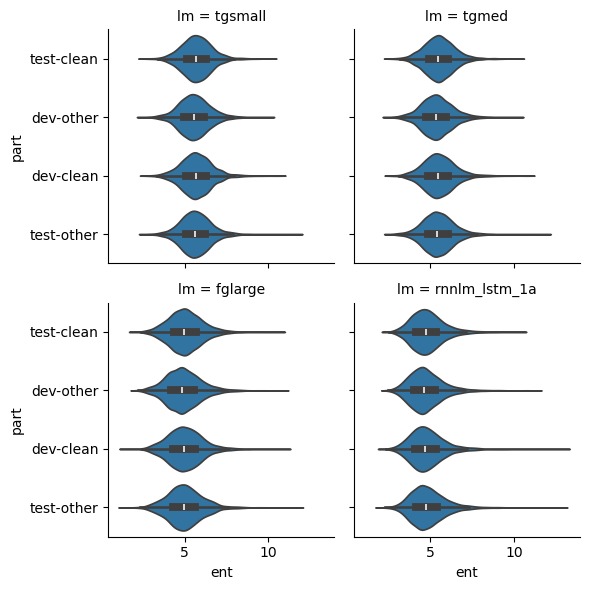

In [8]:
g = sns.FacetGrid(lm_df, col='lm', col_wrap=2)
g.map_dataframe(sns.violinplot, x='ent', y='part')

In [14]:
# highly non-normal..., we'll use spearman correlation
pg.normality(lm_df, dv='ent', group='lm', method='normaltest')

,W,pval,normal
lm,,,
tgsmall,526.438305,4.845901e-115,False
tgmed,678.526111,4.570115e-148,False
fglarge,687.482364,5.189211e-150,False
rnnlm_lstm_1a,2680.772214,0.000000e+00,False


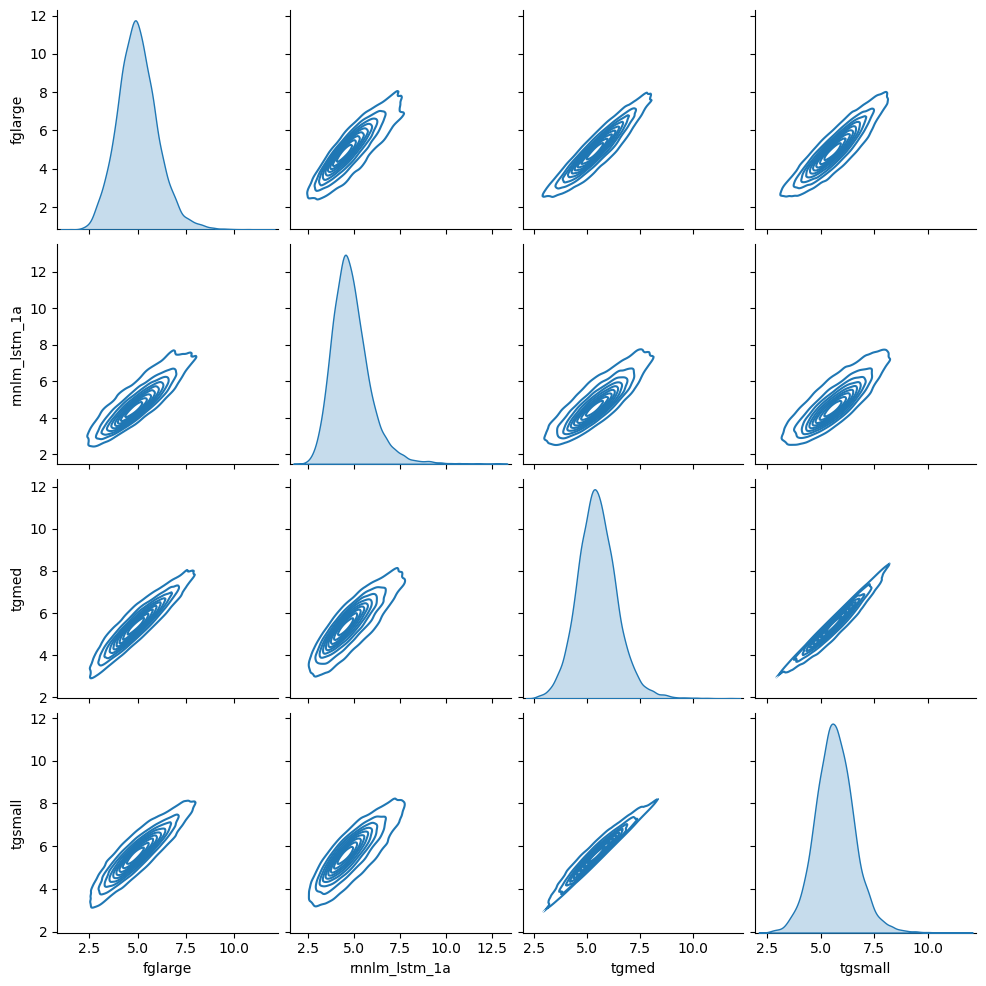

In [9]:
corr_df = lm_df.pivot(values='ent', index='utt', columns='lm')
sns.pairplot(corr_df, kind='kde')

In [16]:
pg.pairwise_corr(corr_df, columns=lms, alternative='greater', method='spearman')

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,tgsmall,tgmed,spearman,greater,11126,0.964522,"[0.96, 1.0]",0.0,1.0
1,tgsmall,fglarge,spearman,greater,11126,0.885817,"[0.88, 1.0]",0.0,1.0
2,tgsmall,rnnlm_lstm_1a,spearman,greater,11126,0.827590,"[0.82, 1.0]",0.0,1.0
3,tgmed,fglarge,spearman,greater,11126,0.918527,"[0.92, 1.0]",0.0,1.0
4,tgmed,rnnlm_lstm_1a,spearman,greater,11126,0.848920,"[0.84, 1.0]",0.0,1.0
5,fglarge,rnnlm_lstm_1a,spearman,greater,11126,0.870730,"[0.87, 1.0]",0.0,1.0
